In [1]:
import pandas as pd
import re
import jieba
from tqdm import tqdm
import torch
from opencc import OpenCC

In [2]:
# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# 读取数据集
data_path = '../datasets/chinese_movie_reviews/chinese_movie_reviews_datasets.jsonl'
df = pd.read_json(data_path, orient='records', lines=True)
print(f'数据数量{len(df)}')
print(df.sample(5))

数据数量508110
                                                  content  stars  label
307506  海报很好看，吸引我去看，有一点特色，但是故事比较牵强，没有伏笔，最后世纪大战用的是动画……e...      2      0
16225   看到有两个加菲猫，过着两种不同的生活，我很自然地想到王子与贫儿，明摆着的情节，不过还是被这只...      4      1
173423           也许历史就像海帕西娅的椭圆的轨迹，你以为已经渐行渐远，转了一圈却又回到了最近点。      5      1
273991  看来我是欣赏不了这样的演员表演了，大家扯着嗓子本色的喊台词，加上丑到cry的妖怪造型，加上中...      2      0
114262                                             中字已收录。      5      1


## 数据预处理

1. 分词
2. 训练Word2Vec：生成一个包含语料库中的每个词的向量空间

In [4]:
# 初始化 OpenCC 转换器（繁转简）
cc = OpenCC('t2s')  # t2s 表示繁体转简体

# 读取停用词表
with open('../datasets/chinese_movie_reviews/stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = [line.strip() for line in f.readlines()]

# 繁体字转简体字
def traditional_to_simplified(text):
    return cc.convert(text)

# 移除数字
def remove_digit(text):
     return re.sub(r'\d+', '', text)

# 分词处理
def tokenize(text):
    return " ".join(jieba.cut(text))

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stopwords])

# 应用预处理
def process_row(text):
    text = remove_digit(text) # 移除数字
    text = traditional_to_simplified(text)  # 繁体字转简体字
    text = re.sub(r"[^\u4e00-\u9fa5]", "", text)  # 只保留汉字字符
    text = tokenize(text)
    text = remove_stopwords(text)
    return text

df["content"] = df["content"].apply(process_row) # 作者在这里大概用了2分钟

# 计算每条文本的长度
sentence_lengths = df["content"].apply(lambda x: len(x.split()))  # 计算每条文本的词数（已经分词）
# 计算最大长度和平均长度
max_length = sentence_lengths.max()
avg_length = sentence_lengths.mean()
print(f"最大文本长度：{max_length}")
print(f"平均文本长度：{avg_length:.2f}")

df.sample(5)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\PC\AppData\Local\Temp\jieba.cache
Loading model cost 0.295 seconds.
Prefix dict has been built successfully.


最大文本长度：625
平均文本长度：21.04


,content,stars,label
381987,黄河 民歌 风土 线 人物 个体 经历 线 好像 没 确定 重点 或者说 有些 疏离 看 会...,3,0
263723,无悔 不悲 感恩 幸福 体验,3,0
265531,好久没 看到 难看 片子,2,0
333061,意境 差太多,3,0
81841,拍到 还 好看 第一部 讲 友情 第二部 讲 玩具 意义 第三部 讲 成长 第四部 讲 爱情...,4,1


#### Word2Vec

`Word2Vec训练很快，一分钟以内就能结束`

In [5]:
import numpy as np
from gensim.models import Word2Vec

def prepare_data(df, vector_size, max_length=100):
    # 将文本转换为词列表
    texts = df['content'].apply(lambda x: x.split())

    # 首先创建一个空的词汇表并添加 <PAD> 词索引为 0
    vocab = {"<PAD>": 0}
    
    # 训练Word2Vec模型
    w2v_model = Word2Vec(sentences=texts, vector_size=vector_size, window=8, min_count=1, workers=4)
    
    # 获取模型训练后生成的词汇表
    vocab.update({k: v+1 for k, v in w2v_model.wv.key_to_index.items()})
    
    # 将文本转换为序列，如果词不在词汇表中，则用0表示
    sequences = [[vocab.get(word, 0) for word in text] for text in texts]

    # 对每个序列进行填充或截断
    padded = [s[:max_length] + [0] * (max_length - len(s)) if len(s) < max_length 
              else s[:max_length] for s in sequences]
    
    embedding_matrix = np.zeros((len(vocab), vector_size))
    for word, i in vocab.items():
        if word != "<PAD>":  # 确保 <PAD> 不会被赋予任何词向量
            embedding_matrix[i] = w2v_model.wv[word]
    
    return np.array(padded), embedding_matrix, vocab

vector_size=32
padded, embedding_matrix, vocab = prepare_data(df, vector_size=vector_size)

In [6]:
# 查看词汇表的前几个词
print(f'词汇表大小： {len(vocab)}')
print("词汇表的一部分:")
for word, idx in list(vocab.items())[:5]:  # 查看前5个词
    print(f"词: {word}, 索引: {idx}")

# 查看嵌入矩阵中对应某个词的词向量
word_to_check = '狗'  
if word_to_check in vocab:
    word_index = vocab[word_to_check]
    word_vector = embedding_matrix[word_index]
    print(f"{word_to_check} 的词向量:")
    print(word_vector)
else:
    print(f"词汇表中没有 {word_to_check} 这个词。")

词汇表大小： 276419
词汇表的一部分:
词: <PAD>, 索引: 0
词: 看, 索引: 1
词: 人, 索引: 2
词: 但, 索引: 3
词: 好, 索引: 4
狗 的词向量:
[ 1.25383043 -2.4116931   0.8064031   1.5779922   2.63155127  1.46873689
 -0.07547206  0.4740181  -3.00884056 -0.86981738  5.24331665 -2.24276662
 -0.24413531 -1.14389253  0.38821632 -2.94821525 -0.94405043 -0.27858946
 -0.30593395  1.86716986  1.91396773  1.72029495  2.04792929  1.61745381
  0.84995091  1.7602905  -0.46382093 -1.88935959 -2.54971528  3.30698657
 -0.37414455  2.08153915  1.61319864  2.43325162 -1.68176603  1.26123619
  1.21501899 -0.10926893  3.18952775 -0.08478293  0.13994861 -1.54906392
  1.66652811  0.08736216  1.62019384  1.28826094  1.43435764  0.80444884
  3.76048446  1.97476625  2.87487316  0.35240531  2.00236297  0.7253406
 -1.14215207 -0.46701586  2.8651166   0.05218291  1.33643413  0.88709491
  0.02159583  1.97483563 -3.71665955 -0.49163347]


#### 构建数据集

In [7]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

X = padded
y = df['label'].values
# stratify=df["label"] 使得训练集和测试集中的标签分布是均匀
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=df["label"])  

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [8]:
# 查看训练集和测试集的大小
print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

# 查看训练集和测试集的标签分布
from collections import Counter

train_labels_counter = Counter(y_train)
test_labels_counter = Counter(y_test)
print(f"训练集标签分布: {train_labels_counter}")
print(f"测试集标签分布: {test_labels_counter}")

训练集大小: 457299
测试集大小: 50811
训练集标签分布: Counter({1: 228650, 0: 228649})
测试集标签分布: Counter({0: 25406, 1: 25405})


## 定义模型

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim=64):
        super().__init__()
        # 定义词嵌入层，使用 embedding_matrix 初始化
        self.embedding = nn.Embedding.from_pretrained(
            torch.FloatTensor(embedding_matrix),
            padding_idx=0
        )
        self.embedding.weight.requires_grad = False # True 确保嵌入层的参数可训练
        """
        双向 LSTM 层：输入维度为 embedding_dim，输出维度为 hidden_dim。
        batch_first=True : 输入张量的形状为 (batch_size, sequence_length)。
        bidirectional=True : LSTM 会在两个方向上（正向和反向）处理输入序列，以捕捉更多上下文信息
        (因为 LSTM 是双向的，它的输出将是两个隐藏层的连接, 所以实际输出维度为 hidden_dim * 2)
        """
        self.lstm = nn.LSTM(
            embedding_dim,    # 输入特征的维度
            hidden_dim,       # 隐藏状态的维度
            num_layers=2,     # LSTM的层数
            batch_first=True, # 输入和输出的张量的第一个维度是batch_size
            bidirectional=True, # 使用双向LSTM
            dropout=0.5
        )
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # 添加一个额外的全连接层
        self.fc2 = nn.Linear(hidden_dim, 2)  # 二分类任务
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded) # 第二个返回值_是LSTM的隐藏状态和单元状态；lstm_out形状： (batch_size, sequence_length, hidden_dim * 2)
        last_hidden = lstm_out[:, -1, :] # 选择每个批次中的最后一个时刻的输出，形状为 (batch_size, hidden_dim * 2)
        dropped = self.dropout(last_hidden)
        fc1_out = F.relu(self.fc1(dropped))
        fc_out = self.fc2(fc1_out)
        return fc_out


model = TextClassifier(len(vocab) + 1, vector_size, embedding_matrix).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 初始化学习率调度器，每step_size个epoch将学习率衰减为原来的gamma倍
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [10]:
# 查看模型结构
# 打印模型参数总数和可训练参数总数
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())  # 所有参数数量
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)  # 需要训练的参数数量
    print(f"模型总参数数量: {total_params:,}")
    print(f"模型可训练参数数量: {trainable_params:,}")

print(model)
count_parameters(model)

TextClassifier(
  (embedding): Embedding(276419, 64, padding_idx=0)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
模型总参数数量: 17,865,090
模型可训练参数数量: 174,274


## 模型训练与评估

In [11]:
from tqdm import tqdm

# 训练函数
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # 设置模型为训练模式
    
    running_loss = 0.0
    correct = 0
    total = 0

    # 使用 tqdm 包裹数据加载器，显示进度条
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for texts, labels in progress_bar:
        # 将数据移动到设备
        texts, labels = texts.to(device), labels.to(device)

        # 前向传播
        outputs = model(texts)
        loss = loss_fn(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  # 更新模型参数

        # 统计指标
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # 更新进度条描述
        progress_bar.set_postfix(lr=optimizer.param_groups[0]['lr'], loss=loss.item())
        
    scheduler.step()  # 更新学习率       

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(dataloader)
    return avg_loss, accuracy

In [12]:
# 测试函数
def evaluate(dataloader, model, loss_fn):
    model.eval()  # 设置模型为评估模式
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 关闭梯度计算
        progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
        for texts, labels in progress_bar:
            # 将数据移动到设备
            texts, labels = texts.to(device), labels.to(device)

            # 前向传播
            outputs = model(texts)
            loss = loss_fn(outputs, labels)

            # 统计指标
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # 更新进度条描述
            progress_bar.set_postfix(loss=loss.item())

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(dataloader)
    return avg_loss, accuracy

In [13]:
# 开始训练

num_epochs = 10

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    epoch_train_loss, epoch_train_acc = train(train_loader, model, loss_fn, optimizer)

    # 在测试集上评估
    epoch_test_loss, epoch_test_acc = evaluate(test_loader, model, loss_fn)

    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    # 打印训练和测试结果
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc, epoch_train_loss, epoch_test_acc, epoch_test_loss))

print("训练完成!")

Epoch 1/10


Epoch: 1, Train_acc:56.4%, Train_loss:0.669, Test_acc:66.4%，Test_loss:0.607
Epoch 2/10


Epoch: 2, Train_acc:66.4%, Train_loss:0.603, Test_acc:67.8%，Test_loss:0.584
Epoch 3/10


Epoch: 3, Train_acc:68.0%, Train_loss:0.585, Test_acc:68.3%，Test_loss:0.579
Epoch 4/10


Epoch: 4, Train_acc:68.4%, Train_loss:0.578, Test_acc:68.7%，Test_loss:0.576
Epoch 5/10


Epoch: 5, Train_acc:69.1%, Train_loss:0.570, Test_acc:68.8%，Test_loss:0.576
Epoch 6/10


Epoch: 6, Train_acc:69.4%, Train_loss:0.566, Test_acc:69.0%，Test_loss:0.574
Epoch 7/10


Epoch: 7, Train_acc:69.7%, Train_loss:0.562, Test_acc:68.9%，Test_loss:0.574
Epoch 8/10


Epoch: 8, Train_acc:69.8%, Train_loss:0.559, Test_acc:69.1%，Test_loss:0.575
Epoch 9/10


Epoch: 9, Train_acc:70.0%, Train_loss:0.557, Test_acc:69.1%，Test_loss:0.573
Epoch 10/10


Epoch:10, Train_acc:70.1%, Train_loss:0.556, Test_acc:69.2%，Test_loss:0.574
训练完成!


## 结果可视化

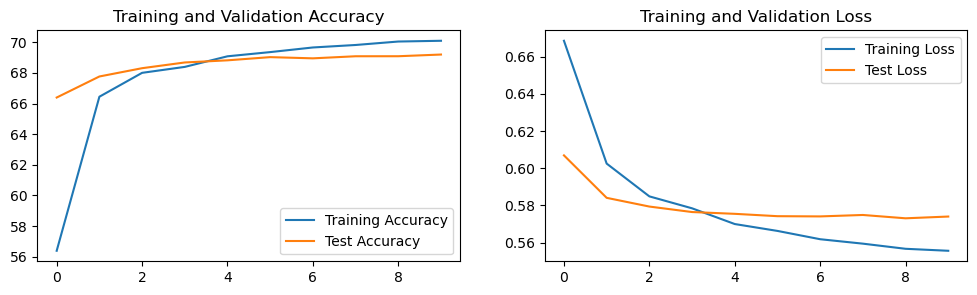

In [14]:
import matplotlib.pyplot as plt

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()